# Exercise 3

## Import packages

In [22]:
import numpy as np
import json
import os
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

## Task 1
(3 points)

Implement the training loop for one training epoch.
An epoch trains on the whole training dataset once.

In [23]:
def train(model, use_cuda, train_loader, optimizer, epoch, log_interval):
    """
    Train one epoch
    
    model -- the neural network
    use_cuda -- true if GPU should be used
    train_loader -- data loader
    optimizer -- network optimizer
    epoch -- number of current epoch
    log_interval -- number of training steps between logs
    """
    # TODO: set the model to train mode
    model.train()
    
    # TODO: enumerate over the dataloader to get mini batches
    #       of images and ground truth labels
    # HINT: the builtin python function enumerate() also gives you indices
    for batch_idx, (data, target) in enumerate(train_loader):
        
        # If CUDA is enabled, move data and target to the GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()

        # TODO: set the optimizers gradients to zero
        optimizer.zero_grad()
        
        # TODO: run the network
        output = model(data)
        
        # TODO: compute negative log likelihood loss
        loss = F.nll_loss(output, target)
        
        # TODO: do backpropagation
        loss.backward()
        
        # TODO: optimize
        optimizer.step()
        
        # TODO: print current loss for every nth ("log_interval"th) iteration
        if batch_idx % log_interval == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
            
    return loss.item()      #Return loss

We already implemented the validation function for you (this is essentially validate() from the last exercise)

In [24]:
def validate(model, use_cuda, test_loader):
    """
    Compute test metrics
    
    model -- the neural network
    use_cuda -- true if GPU should be used
    test_loader -- data loader
    """
    # create a 10x10 grid of subplots
    _, axis = plt.subplots(10, 10)
    
    # set model to evaluation mode
    model.eval()
    test_loss = 0
    correct = 0
    plotted = 0
    
    # disable gradients globally
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            # for each batch
            if use_cuda:
                # transfer to GPU
                data, target = data.cuda()
                target = target.cuda()
            
            # run network and compute metrics
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            
            img_correct = pred.eq(target.view_as(pred))
            correct += pred.eq(target.view_as(pred)).sum().item()
            
            # plot the first 100 images
            img_idx = 0
            data = data.cpu().numpy()
            
            while plotted < 100 and img_idx < data.shape[0]:
                # compute position of ith image in the grid
                y = plotted % 10
                x = plotted // 10
                
                # convert image tensor to numpy array and normalize to [0, 1]
                img = data[img_idx, 0]
                img = (img - np.min(img)) / (np.max(img) - np.min(img))
                
                # make wrongly predicted images red
                img = np.stack([img] * 3, 2)
                if img_correct[img_idx] == 0:
                    img[:, :, 1:] = 0.0
                
                # disable axis and show image
                axis[y][x].axis('off')
                axis[y][x].imshow(img)
                
                # show the predicted class next to each image
                axis[y][x].text(30, 25, pred[img_idx].item())
                
                plotted += 1
                img_idx += 1
            
    test_loss /= len(test_loader.dataset)

    # show results
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    plt.show()

    return 100. * correct / len(test_loader.dataset)        #Return accuracy

## Task 2
(4 points)

Implement a five-layer fully connected neural network.
The dimensions (without batch size) should change like this: 784->200->100->60->30->10
Use log softmax to compute the class predictions.

Run the code at the end of the notebook to train and validate your implementation.

### Task 2.1
* sigmoid non-linear activation function
* note that the last layer does not need an activation function!

### Task 2.2
* add a new class "FCNet2"
* replace sigmoid with ReLU

### Task 2.3
* add a new class "FCNet3"
* add batch normalization to the first and third layers (note the difference between 1D/2D/3D versions)


**NOTE:** The perfomance should improve slightly with each step. However, due to the random weight initialization applied by PyTorch, your results may vary a bit between trainings.

In [25]:
class FCNet1(nn.Module):
    """
    Fully Connected Neural Network
    
    Five fully connected layers with sigmoid non-linearity
    
    Dimensions
    784->200->100->60->30->10
    """
    def __init__(self):
        super(FCNet1, self).__init__()
        
        # TODO: initialize network layers
        # HINT: take a look at "torch.nn" (imported as "nn")
        self.name = 'FCNet1'
        self.flatten = nn.Flatten()
        self.linear0 = nn.Linear(784, 200)
        self.linear1 = nn.Linear(200, 100)
        self.linear2 = nn.Linear(100, 60)
        self.linear3 = nn.Linear(60, 30)
        self.linear4 = nn.Linear(30, 10)
        self.sigmoid = nn.Sigmoid()


    def forward(self, x):
        # TODO: reshape batch of images to batch of 1D vectors
        x = self.flatten(x)
        
        # TODO: run network layers
        x = self.linear0(x)
        x = self.sigmoid(x)
        x = self.linear1(x)
        x = self.sigmoid(x)
        x = self.linear2(x)
        x = self.sigmoid(x)
        x = self.linear3(x)
        x = self.sigmoid(x)
        x = self.linear4(x)

        # TODO: compute log softmax over the output
        # HINT: take a look at "torch.nn.functional" (imported as "F")
        output = F.log_softmax(x)
                
        return output

In [26]:
class FCNet2(nn.Module):
    def __init__(self):
        super(FCNet2, self).__init__()
        
        self.name = 'FCNet2'
        self.flatten = nn.Flatten()
        self.linear0 = nn.Linear(784, 200)
        self.linear1 = nn.Linear(200, 100)
        self.linear2 = nn.Linear(100, 60)
        self.linear3 = nn.Linear(60, 30)
        self.linear4 = nn.Linear(30, 10)
        self.relu = nn.ReLU()
    

    def forward(self, x):
        # TODO: reshape batch of images to batch of 1D vectors
        x = self.flatten(x)
        
        # TODO: run network layers
        x = self.linear0(x)
        x = self.relu(x)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
        x = self.relu(x)
        x = self.linear4(x)

        # TODO: compute log softmax over the output
        # HINT: take a look at "torch.nn.functional" (imported as "F")
        output = F.log_softmax(x)
                
        return output

In [27]:
class FCNet3(nn.Module):
    def __init__(self):
        super(FCNet3, self).__init__()
        self.name = 'FCNet3'
        self.flatten = nn.Flatten()
        self.linear0 = nn.Linear(784, 200)
        self.linear1 = nn.Linear(200, 100)
        self.linear2 = nn.Linear(100, 60)
        self.linear3 = nn.Linear(60, 30)
        self.linear4 = nn.Linear(30, 10)
        self.relu = nn.ReLU()
        self.batchnorm1 = nn.BatchNorm1d(200)
        self.batchnorm3 = nn.BatchNorm1d(60)

    def forward(self, x):
        # TODO: reshape batch of images to batch of 1D vectors
        x = self.flatten(x)
        
        # TODO: run network layers
        x = self.linear0(x)
        x = self.relu(x)
        x = self.batchnorm1(x)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.batchnorm3(x)
        x = self.linear3(x)
        x = self.relu(x)
        x = self.linear4(x)

        # TODO: compute log softmax over the output
        # HINT: take a look at "torch.nn.functional" (imported as "F")
        output = F.log_softmax(x)

        return output

## Task 3
(3 points)

Implement a convolutional neural network, consisting of two convolutional and two fully connected layers.
This time, the dimensions (without batch size) should change like this: 1x28x28->32x26x26->64x12x12->128->10

Output Size= [(Input Size-Kernel Size+2*Padding​)/Stride]+1

### Task 3.1
* two convolutional layers (kernel size 3)
* two fully-connected layers
* ReLU activation function

### Task 3.2
* add batch normalization to first convolutional and first fully connected layer

### Task 3.3
* use max pooling instead of stride to reduce the dimensions to 64x12x12

In [28]:
class ConvNet1(nn.Module):
    """
    Convolutional Neural Network
    
    Two convolutional layers and two fully connected layers
    
    Dimensions:
    1x28x28->32x26x26->64x12x12->128->10
    """
    def __init__(self):
        super(ConvNet1, self).__init__()
        self.name = 'ConvNet1'
        self.conv0 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.conv1 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2)
        self.linear0 = nn.Linear(9216, 128)
        self.linear1 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        # TODO: initialize network layers
        

    def forward(self, x):
        # TODO: run convolutional layers
        x = self.conv0(x)
        x = self.relu(x)
        x= self.conv1(x)
        x = self.relu(x)
        
        # TODO: reshape batch of images to batch of 1D vectors
        x = self.flatten(x)
        
        # TODO: run fully connected layers
        x = self.linear0(x)
        x = self.relu(x)
        x = self.linear1(x)
        x = self.relu(x)
                
        # TODO: compute log softmax over the output
        output = F.log_softmax(x)
        
        
        return output

In [29]:
class ConvNet2(nn.Module):
    def __init__(self):
        super(ConvNet2, self).__init__()
        self.name = 'ConvNet2'
        self.conv0 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.conv1 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2)
        self.linear0 = nn.Linear(9216, 128)
        self.linear1 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.batchnorm0 = nn.BatchNorm2d(32)
        self.batchnorm2 = nn.BatchNorm1d(128)

    def forward(self, x):
        x = self.conv0(x)
        x = self.relu(x)
        x = self.batchnorm0(x)
        x= self.conv1(x)
        x = self.relu(x)
        
        # TODO: reshape batch of images to batch of 1D vectors
        x = self.flatten(x)
        
        # TODO: run fully connected layers
        x = self.linear0(x)
        x = self.relu(x)
        x = self.batchnorm2(x)
        x = self.linear1(x)
        x = self.relu(x)
                
        # TODO: compute log softmax over the output
        output = F.log_softmax(x)
    
        return output

In [30]:
class ConvNet3(nn.Module):
    def __init__(self):
        super(ConvNet3, self).__init__()
        self.name = 'ConvNet3'
        self.conv0 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.conv1 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.linear0 = nn.Linear(9216, 128)
        self.linear1 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.batchnorm0 = nn.BatchNorm2d(32)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv0(x)
        x = self.relu(x)
        x = self.batchnorm0(x)
        x= self.conv1(x)
        x = self.relu(x)

        #maxpooling
        x = self.maxpool(x)
        
        # TODO: reshape batch of images to batch of 1D vectors
        x = self.flatten(x)
        
        # TODO: run fully connected layers
        x = self.linear0(x)
        x = self.relu(x)
        x = self.batchnorm2(x)
        x = self.linear1(x)
        x = self.relu(x)
                
        # TODO: compute log softmax over the output
        output = F.log_softmax(x)
    
        return output

To run all models, please delete the data.json file. To only view the plots please leave the data.json file in the same directory where the notebook is executed.

model: FCNet1
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.299672


/tmp/ipykernel_87850/3883066910.py:42: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.306179
Train Epoch: 0 [12800/60000 (21%)]	Loss: 2.310358
Train Epoch: 0 [19200/60000 (32%)]	Loss: 2.311991
Train Epoch: 0 [25600/60000 (43%)]	Loss: 2.305896
Train Epoch: 0 [32000/60000 (53%)]	Loss: 2.298061
Train Epoch: 0 [38400/60000 (64%)]	Loss: 2.292584
Train Epoch: 0 [44800/60000 (75%)]	Loss: 2.292960
Train Epoch: 0 [51200/60000 (85%)]	Loss: 2.003154
Train Epoch: 0 [57600/60000 (96%)]	Loss: 1.763686

Test set: Average loss: 1.7345, Accuracy: 3418/10000 (34.18%)



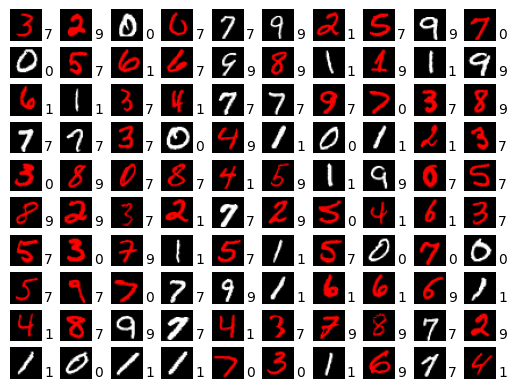

Train Epoch: 1 [0/60000 (0%)]	Loss: 1.742663
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.769986
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.742011
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.224810
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.043990
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.819055
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.811136
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.576817
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.766660
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.688125

Test set: Average loss: 0.5565, Accuracy: 8649/10000 (86.49%)



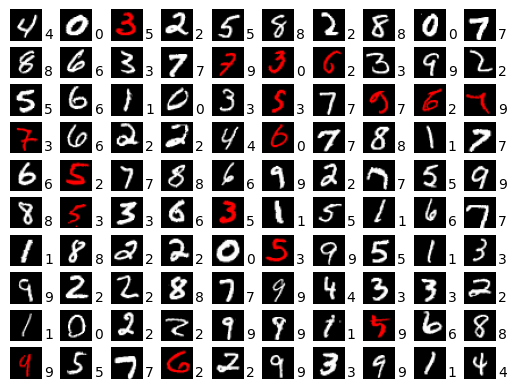

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.542968
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.565374
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.417482
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.739129
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.503468
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.427925
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.551499
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.336447
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.457843
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.158624

Test set: Average loss: 0.3298, Accuracy: 9241/10000 (92.41%)



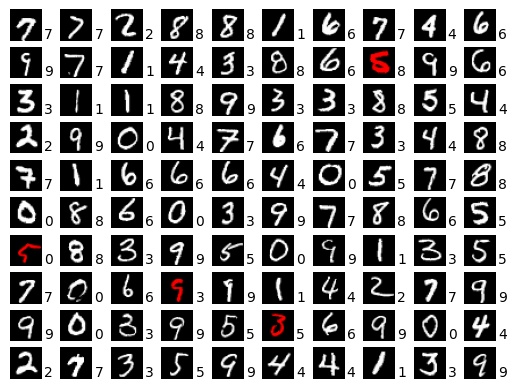

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.306126
Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.223911
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.155718
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.225965
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.391366
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.470481
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.292149
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.192825
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.201357
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.527684

Test set: Average loss: 0.2794, Accuracy: 9343/10000 (93.43%)



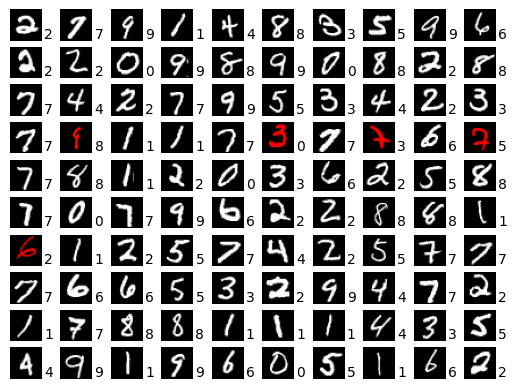

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.352853
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.249348
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.123890
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.071670
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.123267
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.277923
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.209796
Train Epoch: 4 [44800/60000 (75%)]	Loss: 0.216366
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.196685
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.229117

Test set: Average loss: 0.2330, Accuracy: 9445/10000 (94.45%)



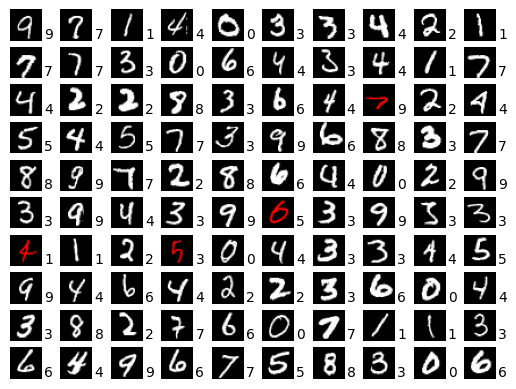

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.144987
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.099532
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.089209
Train Epoch: 5 [19200/60000 (32%)]	Loss: 0.109295
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.053794
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.158541
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.061125
Train Epoch: 5 [44800/60000 (75%)]	Loss: 0.353439
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.142334
Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.179510

Test set: Average loss: 0.2032, Accuracy: 9509/10000 (95.09%)



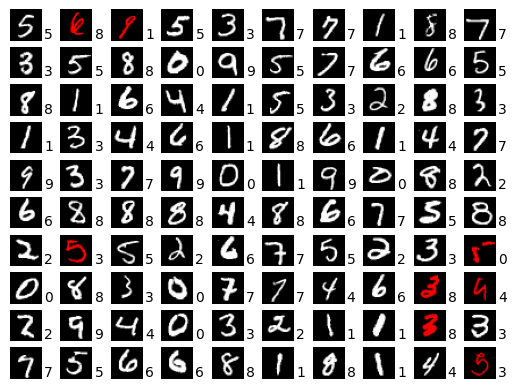

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.143255
Train Epoch: 6 [6400/60000 (11%)]	Loss: 0.123978
Train Epoch: 6 [12800/60000 (21%)]	Loss: 0.137154
Train Epoch: 6 [19200/60000 (32%)]	Loss: 0.146373
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.104670
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.159313
Train Epoch: 6 [38400/60000 (64%)]	Loss: 0.244587
Train Epoch: 6 [44800/60000 (75%)]	Loss: 0.112496
Train Epoch: 6 [51200/60000 (85%)]	Loss: 0.060354
Train Epoch: 6 [57600/60000 (96%)]	Loss: 0.113212

Test set: Average loss: 0.2014, Accuracy: 9537/10000 (95.37%)



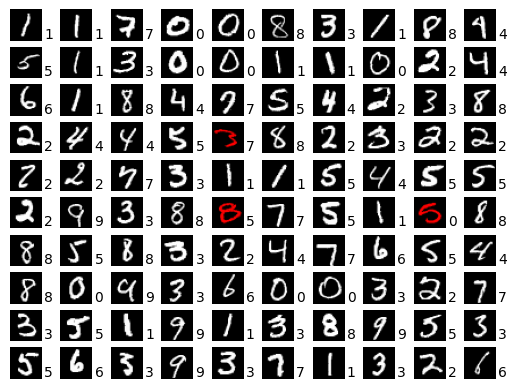

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.083079
Train Epoch: 7 [6400/60000 (11%)]	Loss: 0.165580
Train Epoch: 7 [12800/60000 (21%)]	Loss: 0.053788
Train Epoch: 7 [19200/60000 (32%)]	Loss: 0.088178
Train Epoch: 7 [25600/60000 (43%)]	Loss: 0.084019
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.070879
Train Epoch: 7 [38400/60000 (64%)]	Loss: 0.169549
Train Epoch: 7 [44800/60000 (75%)]	Loss: 0.235740
Train Epoch: 7 [51200/60000 (85%)]	Loss: 0.044603
Train Epoch: 7 [57600/60000 (96%)]	Loss: 0.045938

Test set: Average loss: 0.1906, Accuracy: 9545/10000 (95.45%)



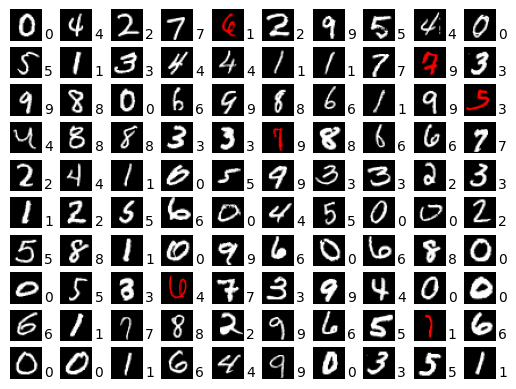

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.094135
Train Epoch: 8 [6400/60000 (11%)]	Loss: 0.192622
Train Epoch: 8 [12800/60000 (21%)]	Loss: 0.073170
Train Epoch: 8 [19200/60000 (32%)]	Loss: 0.180088
Train Epoch: 8 [25600/60000 (43%)]	Loss: 0.080374
Train Epoch: 8 [32000/60000 (53%)]	Loss: 0.125154
Train Epoch: 8 [38400/60000 (64%)]	Loss: 0.086817
Train Epoch: 8 [44800/60000 (75%)]	Loss: 0.038612
Train Epoch: 8 [51200/60000 (85%)]	Loss: 0.059514
Train Epoch: 8 [57600/60000 (96%)]	Loss: 0.067028

Test set: Average loss: 0.1878, Accuracy: 9553/10000 (95.53%)



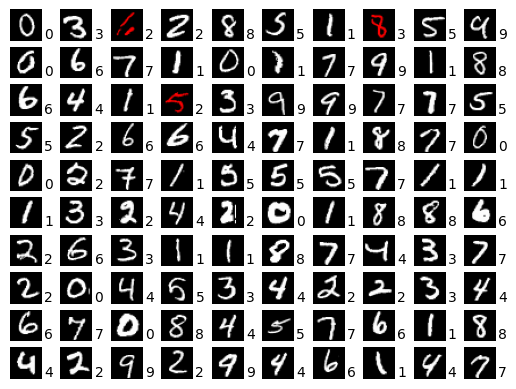

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.037292
Train Epoch: 9 [6400/60000 (11%)]	Loss: 0.175638
Train Epoch: 9 [12800/60000 (21%)]	Loss: 0.254321
Train Epoch: 9 [19200/60000 (32%)]	Loss: 0.224023
Train Epoch: 9 [25600/60000 (43%)]	Loss: 0.150992
Train Epoch: 9 [32000/60000 (53%)]	Loss: 0.114466
Train Epoch: 9 [38400/60000 (64%)]	Loss: 0.073402
Train Epoch: 9 [44800/60000 (75%)]	Loss: 0.042808
Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.047653
Train Epoch: 9 [57600/60000 (96%)]	Loss: 0.116464

Test set: Average loss: 0.1848, Accuracy: 9556/10000 (95.56%)



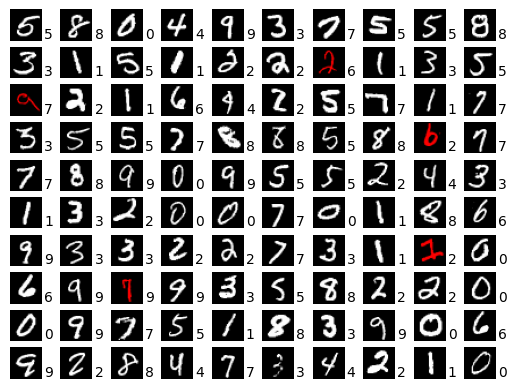

model: FCNet2
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.307537


/tmp/ipykernel_87850/3023729954.py:32: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.519463
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.292486
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.196476
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.364883
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.049430
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.060482
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.269990
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.049220
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.063005

Test set: Average loss: 0.1739, Accuracy: 9482/10000 (94.82%)



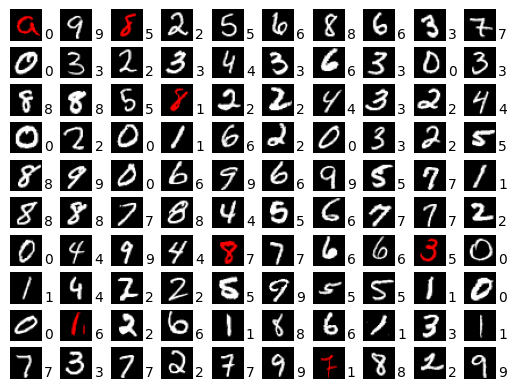

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.146373
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.112858
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.163119
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.131126
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.057772
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.047215
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.014895
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.009894
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.016767
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.039042

Test set: Average loss: 0.1074, Accuracy: 9702/10000 (97.02%)



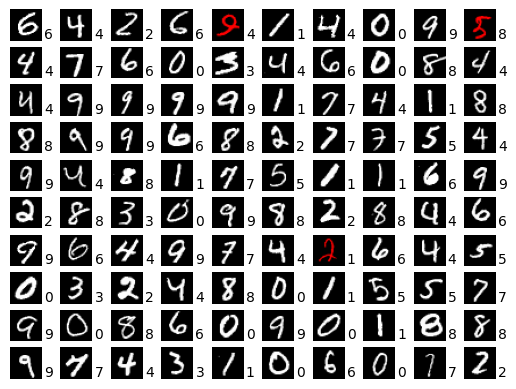

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.184689
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.065563
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.031119
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.117114
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.037948
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.135024
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.009812
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.006933
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.056016
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.003769

Test set: Average loss: 0.0824, Accuracy: 9790/10000 (97.90%)



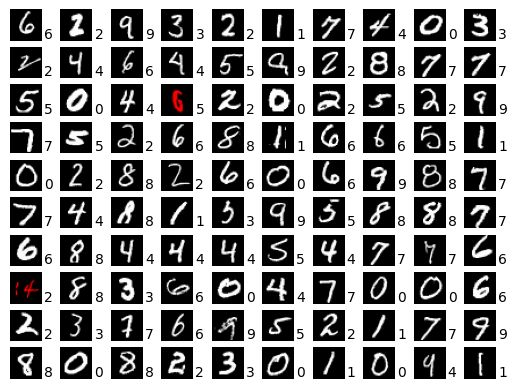

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.065905
Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.065526
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.028893
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.040427
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.002522
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.010212
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.003403
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.042116
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.088873
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.013667

Test set: Average loss: 0.0798, Accuracy: 9821/10000 (98.21%)



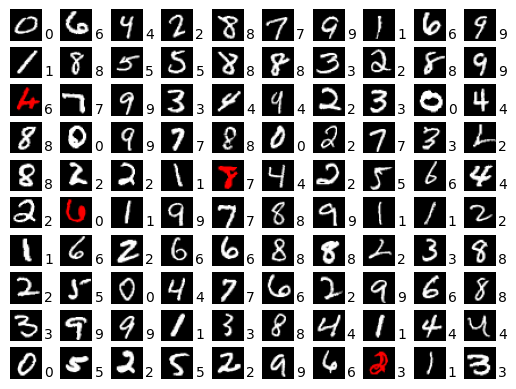

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.000373
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.010113
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.019173
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.007160
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.092177
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.022648
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.002278
Train Epoch: 4 [44800/60000 (75%)]	Loss: 0.022449
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.005749
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.049500

Test set: Average loss: 0.0801, Accuracy: 9828/10000 (98.28%)



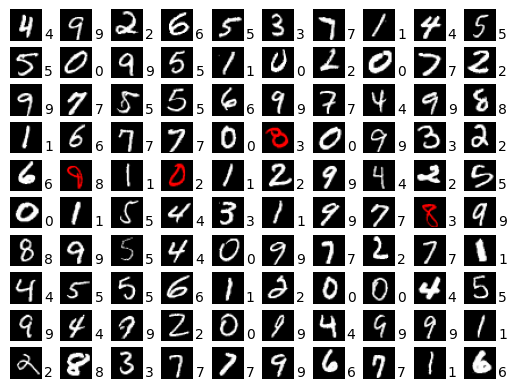

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.121732
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.001959
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.000809
Train Epoch: 5 [19200/60000 (32%)]	Loss: 0.002747
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.001737
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.005951
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.010132
Train Epoch: 5 [44800/60000 (75%)]	Loss: 0.000476
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.001985
Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.000743

Test set: Average loss: 0.0822, Accuracy: 9836/10000 (98.36%)



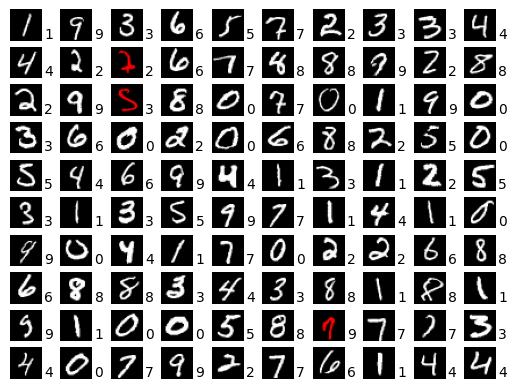

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.001280
Train Epoch: 6 [6400/60000 (11%)]	Loss: 0.006767
Train Epoch: 6 [12800/60000 (21%)]	Loss: 0.000124
Train Epoch: 6 [19200/60000 (32%)]	Loss: 0.007597
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.003859
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.036043
Train Epoch: 6 [38400/60000 (64%)]	Loss: 0.000583
Train Epoch: 6 [44800/60000 (75%)]	Loss: 0.003932
Train Epoch: 6 [51200/60000 (85%)]	Loss: 0.016221
Train Epoch: 6 [57600/60000 (96%)]	Loss: 0.189040

Test set: Average loss: 0.0876, Accuracy: 9820/10000 (98.20%)



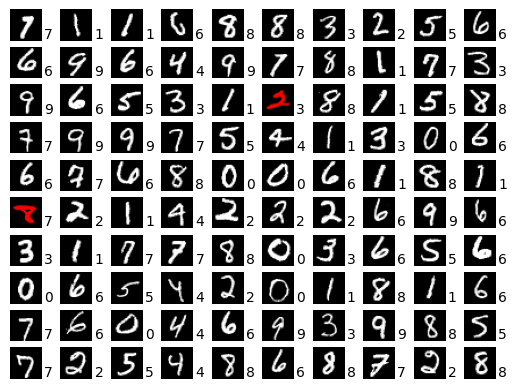

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.000700
Train Epoch: 7 [6400/60000 (11%)]	Loss: 0.103227
Train Epoch: 7 [12800/60000 (21%)]	Loss: 0.005837
Train Epoch: 7 [19200/60000 (32%)]	Loss: 0.007743
Train Epoch: 7 [25600/60000 (43%)]	Loss: 0.000698
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.120763
Train Epoch: 7 [38400/60000 (64%)]	Loss: 0.000108
Train Epoch: 7 [44800/60000 (75%)]	Loss: 0.012315
Train Epoch: 7 [51200/60000 (85%)]	Loss: 0.002628
Train Epoch: 7 [57600/60000 (96%)]	Loss: 0.007241

Test set: Average loss: 0.0895, Accuracy: 9825/10000 (98.25%)



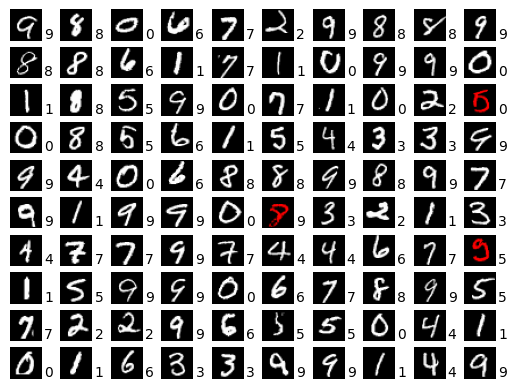

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.000242
Train Epoch: 8 [6400/60000 (11%)]	Loss: 0.003189
Train Epoch: 8 [12800/60000 (21%)]	Loss: 0.001071
Train Epoch: 8 [19200/60000 (32%)]	Loss: 0.000105
Train Epoch: 8 [25600/60000 (43%)]	Loss: 0.001311
Train Epoch: 8 [32000/60000 (53%)]	Loss: 0.000117
Train Epoch: 8 [38400/60000 (64%)]	Loss: 0.000342
Train Epoch: 8 [44800/60000 (75%)]	Loss: 0.001557
Train Epoch: 8 [51200/60000 (85%)]	Loss: 0.002175
Train Epoch: 8 [57600/60000 (96%)]	Loss: 0.000663

Test set: Average loss: 0.0906, Accuracy: 9825/10000 (98.25%)



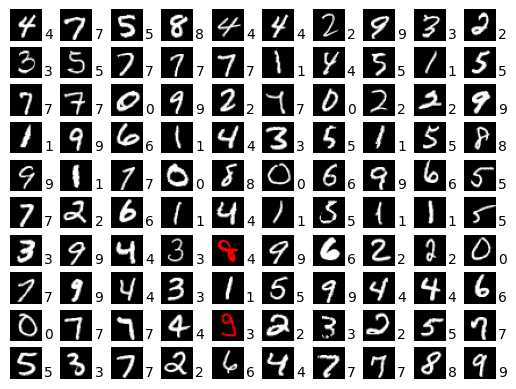

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.000385
Train Epoch: 9 [6400/60000 (11%)]	Loss: 0.004069
Train Epoch: 9 [12800/60000 (21%)]	Loss: 0.002118
Train Epoch: 9 [19200/60000 (32%)]	Loss: 0.001858
Train Epoch: 9 [25600/60000 (43%)]	Loss: 0.030895
Train Epoch: 9 [32000/60000 (53%)]	Loss: 0.001041
Train Epoch: 9 [38400/60000 (64%)]	Loss: 0.034277
Train Epoch: 9 [44800/60000 (75%)]	Loss: 0.002562
Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.000491
Train Epoch: 9 [57600/60000 (96%)]	Loss: 0.006453

Test set: Average loss: 0.0920, Accuracy: 9822/10000 (98.22%)



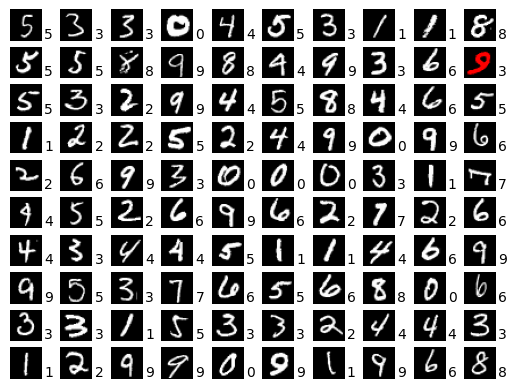

model: FCNet3
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.283161


/tmp/ipykernel_87850/1538799240.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.420270
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.325716
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.201970
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.230325
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.136248
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.292682
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.163007
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.146263
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.058920

Test set: Average loss: 0.1424, Accuracy: 9604/10000 (96.04%)



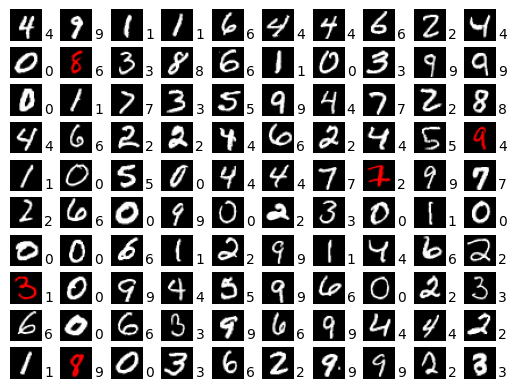

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.238166
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.122344
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.180507
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.018719
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.110415
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.044817
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.015437
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.025339
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.032012
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.170113

Test set: Average loss: 0.0916, Accuracy: 9733/10000 (97.33%)



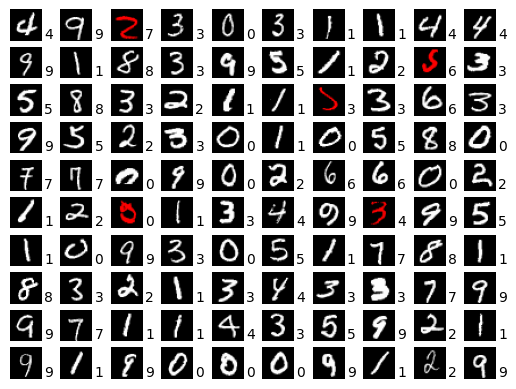

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.017504
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.065248
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.049866
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.016801
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.260358
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.025769
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.096650
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.104215
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.016431
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.014293

Test set: Average loss: 0.0783, Accuracy: 9795/10000 (97.95%)



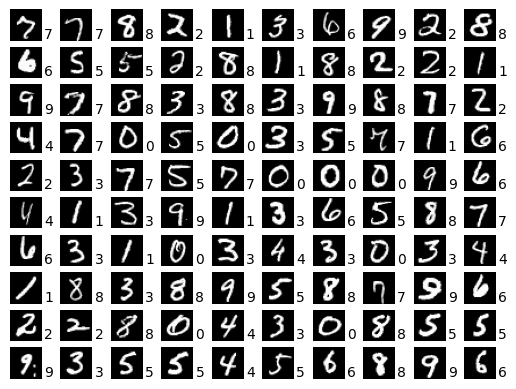

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.048944
Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.004261
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.043446
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.024139
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.033763
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.002480
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.064859
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.009645
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.067290
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.166027

Test set: Average loss: 0.0789, Accuracy: 9808/10000 (98.08%)



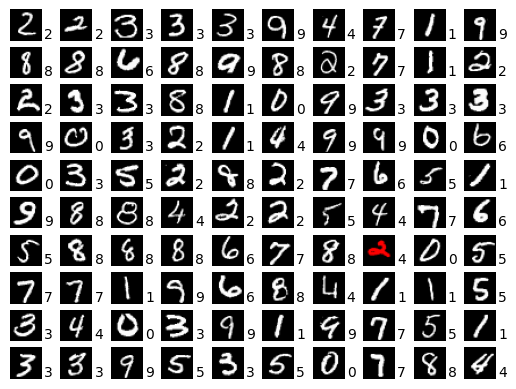

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.006544
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.000782
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.012445
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.005433
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.042704
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.000747
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.045828
Train Epoch: 4 [44800/60000 (75%)]	Loss: 0.017833
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.002938
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.024415

Test set: Average loss: 0.0761, Accuracy: 9824/10000 (98.24%)



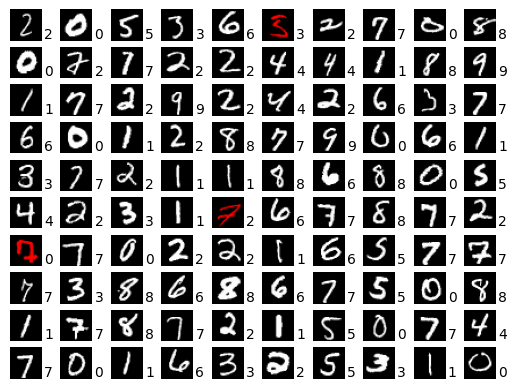

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.062250
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.002382
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.003109
Train Epoch: 5 [19200/60000 (32%)]	Loss: 0.002346
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.006641
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.035571
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.019547
Train Epoch: 5 [44800/60000 (75%)]	Loss: 0.007368
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.003798
Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.007156

Test set: Average loss: 0.0780, Accuracy: 9826/10000 (98.26%)



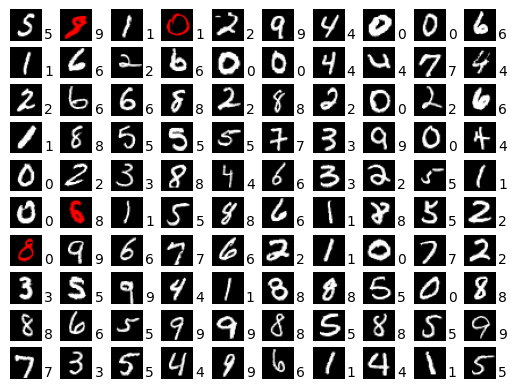

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.020989
Train Epoch: 6 [6400/60000 (11%)]	Loss: 0.058812
Train Epoch: 6 [12800/60000 (21%)]	Loss: 0.153566
Train Epoch: 6 [19200/60000 (32%)]	Loss: 0.037726
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.002247
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.001985
Train Epoch: 6 [38400/60000 (64%)]	Loss: 0.006087
Train Epoch: 6 [44800/60000 (75%)]	Loss: 0.013725
Train Epoch: 6 [51200/60000 (85%)]	Loss: 0.026822
Train Epoch: 6 [57600/60000 (96%)]	Loss: 0.003751

Test set: Average loss: 0.0734, Accuracy: 9830/10000 (98.30%)



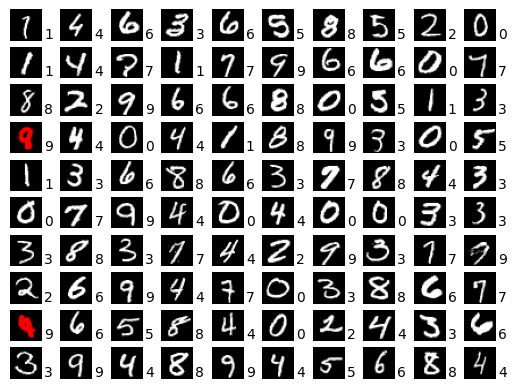

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.002239
Train Epoch: 7 [6400/60000 (11%)]	Loss: 0.004114
Train Epoch: 7 [12800/60000 (21%)]	Loss: 0.001321
Train Epoch: 7 [19200/60000 (32%)]	Loss: 0.005701
Train Epoch: 7 [25600/60000 (43%)]	Loss: 0.005902
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.059803
Train Epoch: 7 [38400/60000 (64%)]	Loss: 0.064230
Train Epoch: 7 [44800/60000 (75%)]	Loss: 0.004450
Train Epoch: 7 [51200/60000 (85%)]	Loss: 0.005776
Train Epoch: 7 [57600/60000 (96%)]	Loss: 0.000729

Test set: Average loss: 0.0694, Accuracy: 9836/10000 (98.36%)



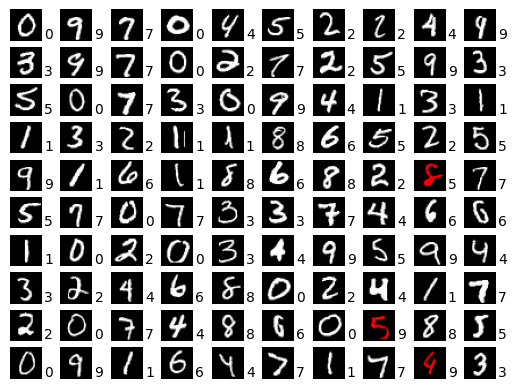

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.068427
Train Epoch: 8 [6400/60000 (11%)]	Loss: 0.001516
Train Epoch: 8 [12800/60000 (21%)]	Loss: 0.000816
Train Epoch: 8 [19200/60000 (32%)]	Loss: 0.001335
Train Epoch: 8 [25600/60000 (43%)]	Loss: 0.001275
Train Epoch: 8 [32000/60000 (53%)]	Loss: 0.029627
Train Epoch: 8 [38400/60000 (64%)]	Loss: 0.002037
Train Epoch: 8 [44800/60000 (75%)]	Loss: 0.000624
Train Epoch: 8 [51200/60000 (85%)]	Loss: 0.005595
Train Epoch: 8 [57600/60000 (96%)]	Loss: 0.044180

Test set: Average loss: 0.0707, Accuracy: 9841/10000 (98.41%)



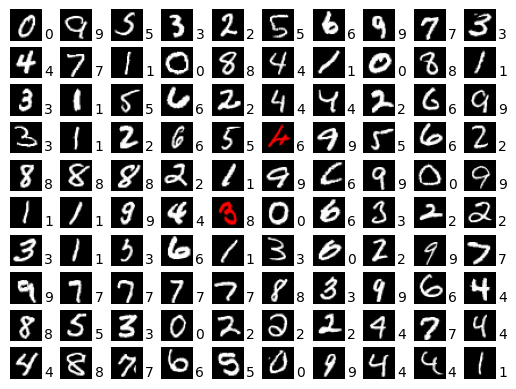

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.000720
Train Epoch: 9 [6400/60000 (11%)]	Loss: 0.004904
Train Epoch: 9 [12800/60000 (21%)]	Loss: 0.017916
Train Epoch: 9 [19200/60000 (32%)]	Loss: 0.001583
Train Epoch: 9 [25600/60000 (43%)]	Loss: 0.002570
Train Epoch: 9 [32000/60000 (53%)]	Loss: 0.016221
Train Epoch: 9 [38400/60000 (64%)]	Loss: 0.010429
Train Epoch: 9 [44800/60000 (75%)]	Loss: 0.005306
Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.000902
Train Epoch: 9 [57600/60000 (96%)]	Loss: 0.008082

Test set: Average loss: 0.0652, Accuracy: 9835/10000 (98.35%)



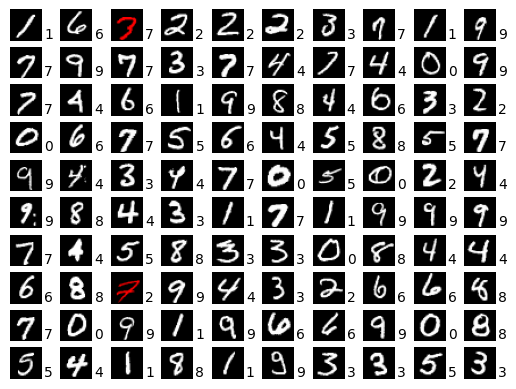

model: ConvNet1
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.303519


/tmp/ipykernel_87850/542480128.py:39: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.774715
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.491403
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.498218
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.474969
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.669014
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.503899
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.468629
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.750708
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.551701

Test set: Average loss: 0.2968, Accuracy: 8870/10000 (88.70%)



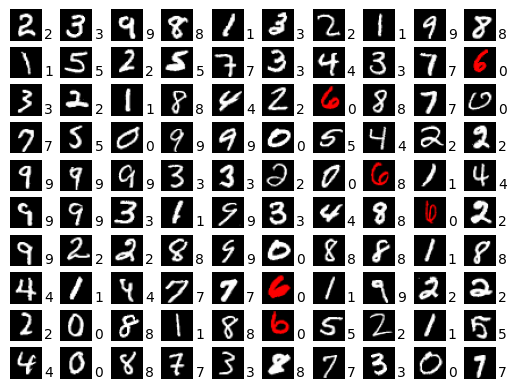

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.363937
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.185048
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.366595
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.128626
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.279994
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.317445
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.224783
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.291160
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.211424
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.302169

Test set: Average loss: 0.2564, Accuracy: 8932/10000 (89.32%)



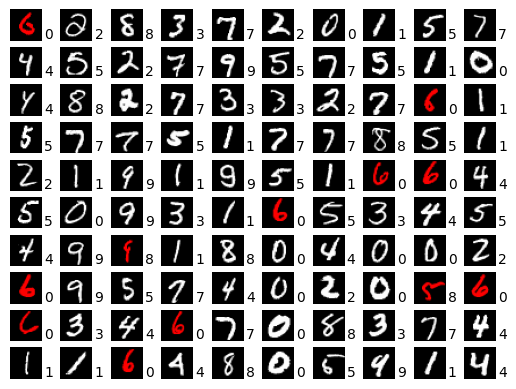

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.187806
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.259498
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.270151
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.076427
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.295763
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.182842
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.392467
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.181165
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.223559
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.244781

Test set: Average loss: 0.2500, Accuracy: 8959/10000 (89.59%)



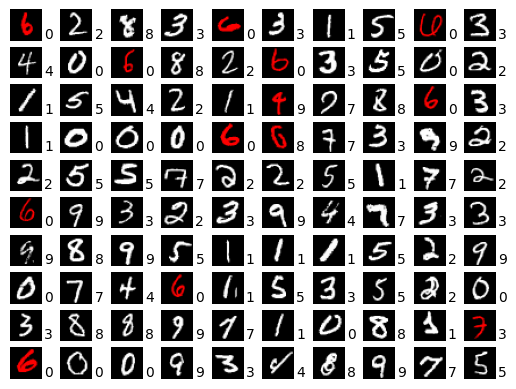

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.326434
Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.181318
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.235455
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.252143
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.432262
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.253262
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.108500
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.254033
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.361431
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.222796

Test set: Average loss: 0.2492, Accuracy: 8964/10000 (89.64%)



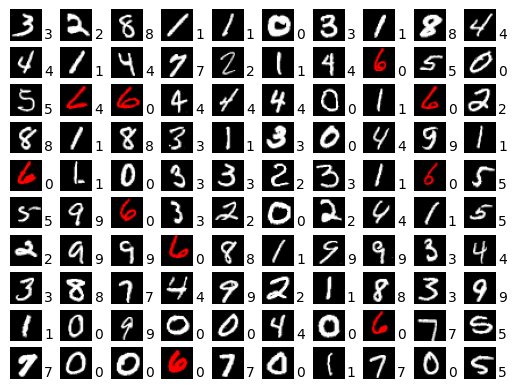

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.217924
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.337774
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.359867
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.216307
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.325168
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.242033
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.251995
Train Epoch: 4 [44800/60000 (75%)]	Loss: 0.143943
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.180014
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.216167

Test set: Average loss: 0.2518, Accuracy: 8959/10000 (89.59%)



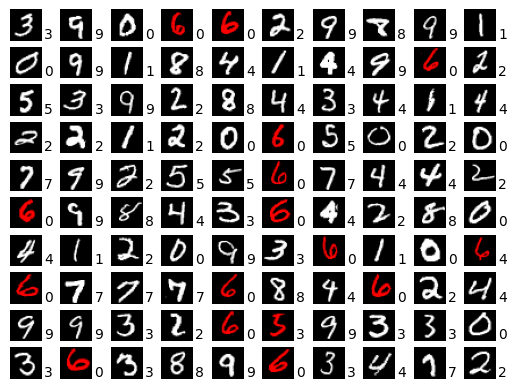

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.216889
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.182345
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.145055
Train Epoch: 5 [19200/60000 (32%)]	Loss: 0.324975
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.360012
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.219122
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.216177
Train Epoch: 5 [44800/60000 (75%)]	Loss: 0.251890
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.289317
Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.433419

Test set: Average loss: 0.2531, Accuracy: 8966/10000 (89.66%)



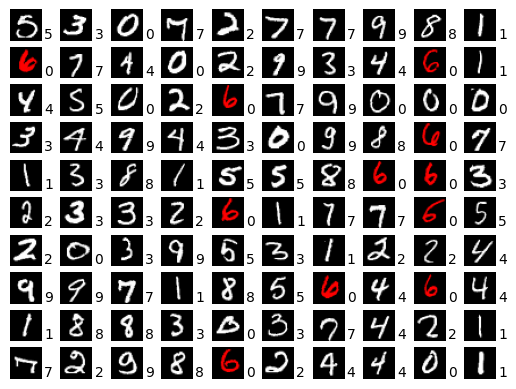

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.181763
Train Epoch: 6 [6400/60000 (11%)]	Loss: 0.324201
Train Epoch: 6 [12800/60000 (21%)]	Loss: 0.324471
Train Epoch: 6 [19200/60000 (32%)]	Loss: 0.108198
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.323886
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.216350
Train Epoch: 6 [38400/60000 (64%)]	Loss: 0.216956
Train Epoch: 6 [44800/60000 (75%)]	Loss: 0.180648
Train Epoch: 6 [51200/60000 (85%)]	Loss: 0.143918
Train Epoch: 6 [57600/60000 (96%)]	Loss: 0.287947

Test set: Average loss: 0.2539, Accuracy: 8965/10000 (89.65%)



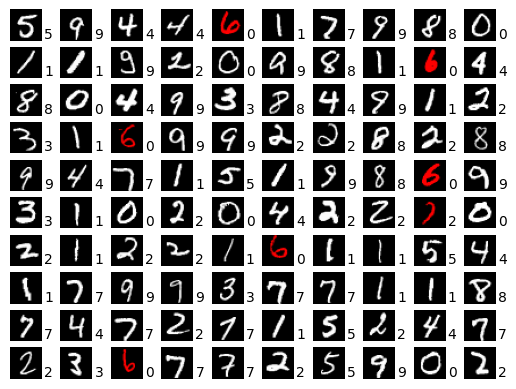

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.252532
Train Epoch: 7 [6400/60000 (11%)]	Loss: 0.362007
Train Epoch: 7 [12800/60000 (21%)]	Loss: 0.253133
Train Epoch: 7 [19200/60000 (32%)]	Loss: 0.180410
Train Epoch: 7 [25600/60000 (43%)]	Loss: 0.144618
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.287894
Train Epoch: 7 [38400/60000 (64%)]	Loss: 0.145122
Train Epoch: 7 [44800/60000 (75%)]	Loss: 0.179905
Train Epoch: 7 [51200/60000 (85%)]	Loss: 0.180731
Train Epoch: 7 [57600/60000 (96%)]	Loss: 0.323917

Test set: Average loss: 0.2541, Accuracy: 8965/10000 (89.65%)



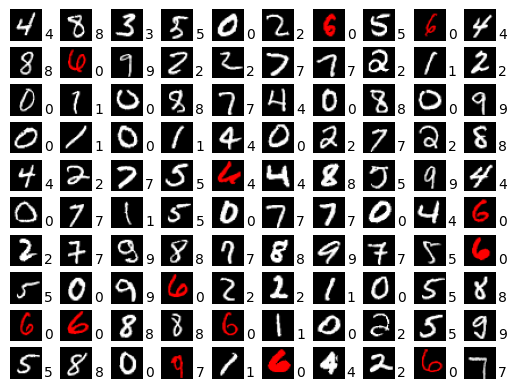

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.251897
Train Epoch: 8 [6400/60000 (11%)]	Loss: 0.218219
Train Epoch: 8 [12800/60000 (21%)]	Loss: 0.179959
Train Epoch: 8 [19200/60000 (32%)]	Loss: 0.180108
Train Epoch: 8 [25600/60000 (43%)]	Loss: 0.108474
Train Epoch: 8 [32000/60000 (53%)]	Loss: 0.288275
Train Epoch: 8 [38400/60000 (64%)]	Loss: 0.181456
Train Epoch: 8 [44800/60000 (75%)]	Loss: 0.180907
Train Epoch: 8 [51200/60000 (85%)]	Loss: 0.216389
Train Epoch: 8 [57600/60000 (96%)]	Loss: 0.143962

Test set: Average loss: 0.2552, Accuracy: 8966/10000 (89.66%)



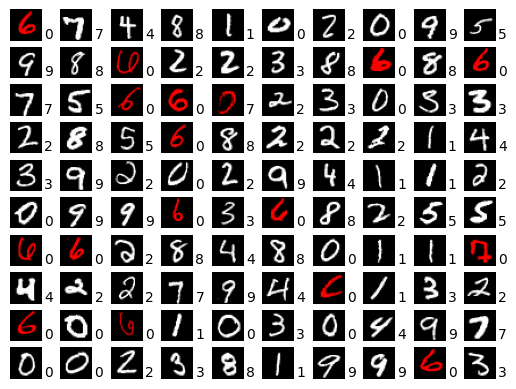

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.108410
Train Epoch: 9 [6400/60000 (11%)]	Loss: 0.072727
Train Epoch: 9 [12800/60000 (21%)]	Loss: 0.252246
Train Epoch: 9 [19200/60000 (32%)]	Loss: 0.072215
Train Epoch: 9 [25600/60000 (43%)]	Loss: 0.288111
Train Epoch: 9 [32000/60000 (53%)]	Loss: 0.216112
Train Epoch: 9 [38400/60000 (64%)]	Loss: 0.251867
Train Epoch: 9 [44800/60000 (75%)]	Loss: 0.216224
Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.180152
Train Epoch: 9 [57600/60000 (96%)]	Loss: 0.179988

Test set: Average loss: 0.2558, Accuracy: 8965/10000 (89.65%)



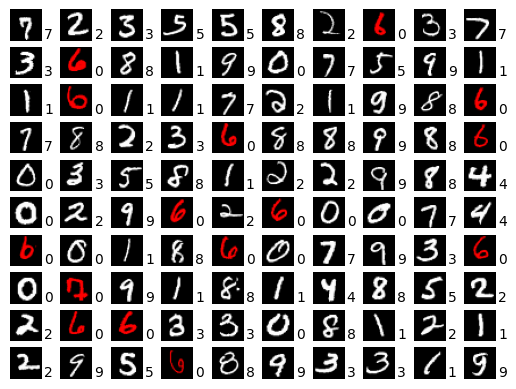

model: ConvNet2
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.418970
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.106444
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.118588
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.106463
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.024721
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.065039
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.064334
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.009920
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.023125
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.017169

Test set: Average loss: 0.0464, Accuracy: 9840/10000 (98.40%)



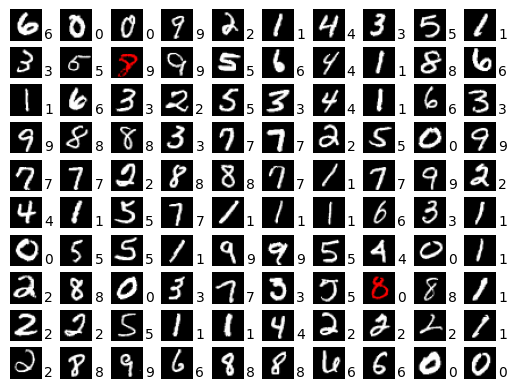

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.071710
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.056396
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.130882
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.007267
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.022552
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.002680
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.044655
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.045113
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.057963
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.071760

Test set: Average loss: 0.0392, Accuracy: 9871/10000 (98.71%)



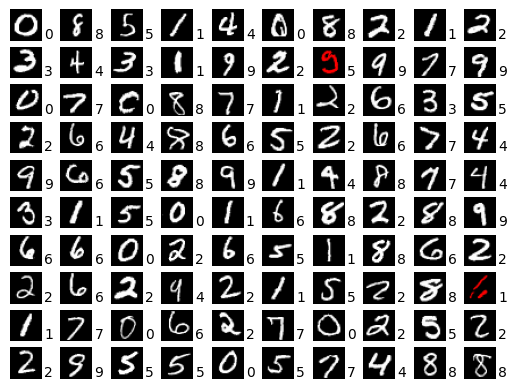

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.004828
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.011320
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.003620
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.001281
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.002031
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.000945
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.029630
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.004726
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.002782
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.003691

Test set: Average loss: 0.0308, Accuracy: 9902/10000 (99.02%)



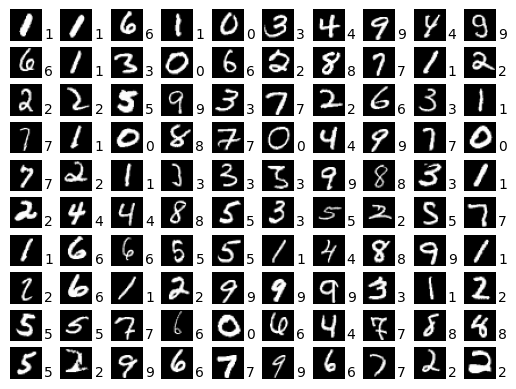

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.001808
Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.001882
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.000457
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.002143
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.000474
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.003273
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.005329
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.009671
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.000277
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.002303

Test set: Average loss: 0.0305, Accuracy: 9901/10000 (99.01%)



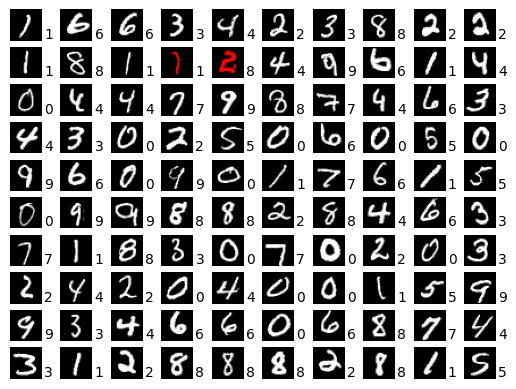

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.001576
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.000326
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.001719
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.000618
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.002925
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.000234
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.000820
Train Epoch: 4 [44800/60000 (75%)]	Loss: 0.000647
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.000313
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.001706

Test set: Average loss: 0.0306, Accuracy: 9902/10000 (99.02%)



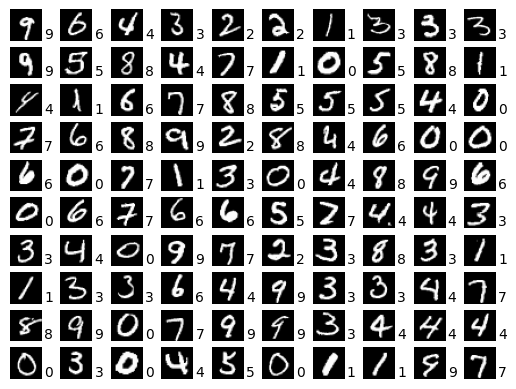

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.000330
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.000397
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.001132
Train Epoch: 5 [19200/60000 (32%)]	Loss: 0.001226
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.001864
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.000883
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.000660
Train Epoch: 5 [44800/60000 (75%)]	Loss: 0.003520
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.005703
Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.000354

Test set: Average loss: 0.0297, Accuracy: 9904/10000 (99.04%)



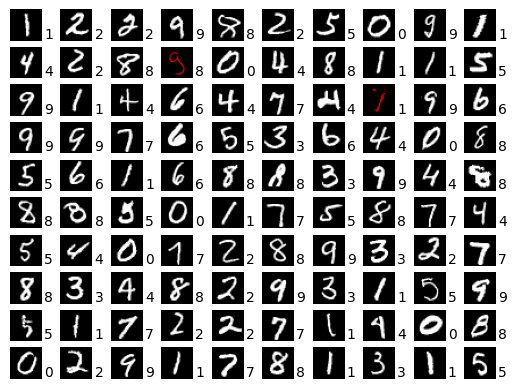

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.002921
Train Epoch: 6 [6400/60000 (11%)]	Loss: 0.001540
Train Epoch: 6 [12800/60000 (21%)]	Loss: 0.004983
Train Epoch: 6 [19200/60000 (32%)]	Loss: 0.001343
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.000428
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.001586
Train Epoch: 6 [38400/60000 (64%)]	Loss: 0.002887
Train Epoch: 6 [44800/60000 (75%)]	Loss: 0.001577
Train Epoch: 6 [51200/60000 (85%)]	Loss: 0.000750
Train Epoch: 6 [57600/60000 (96%)]	Loss: 0.000199

Test set: Average loss: 0.0305, Accuracy: 9906/10000 (99.06%)



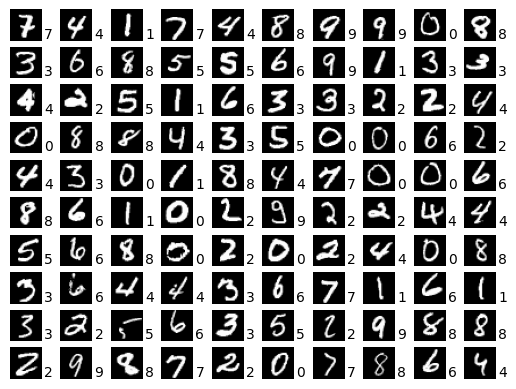

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.001090
Train Epoch: 7 [6400/60000 (11%)]	Loss: 0.004091
Train Epoch: 7 [12800/60000 (21%)]	Loss: 0.003772
Train Epoch: 7 [19200/60000 (32%)]	Loss: 0.011292
Train Epoch: 7 [25600/60000 (43%)]	Loss: 0.000269
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.000469
Train Epoch: 7 [38400/60000 (64%)]	Loss: 0.000569
Train Epoch: 7 [44800/60000 (75%)]	Loss: 0.000183
Train Epoch: 7 [51200/60000 (85%)]	Loss: 0.000172
Train Epoch: 7 [57600/60000 (96%)]	Loss: 0.000211

Test set: Average loss: 0.0313, Accuracy: 9901/10000 (99.01%)



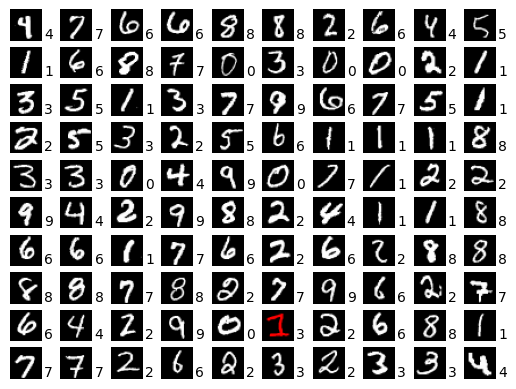

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.000847
Train Epoch: 8 [6400/60000 (11%)]	Loss: 0.000422
Train Epoch: 8 [12800/60000 (21%)]	Loss: 0.003225
Train Epoch: 8 [19200/60000 (32%)]	Loss: 0.000462
Train Epoch: 8 [25600/60000 (43%)]	Loss: 0.001989
Train Epoch: 8 [32000/60000 (53%)]	Loss: 0.000337
Train Epoch: 8 [38400/60000 (64%)]	Loss: 0.000919
Train Epoch: 8 [44800/60000 (75%)]	Loss: 0.000492
Train Epoch: 8 [51200/60000 (85%)]	Loss: 0.000988
Train Epoch: 8 [57600/60000 (96%)]	Loss: 0.000676

Test set: Average loss: 0.0312, Accuracy: 9903/10000 (99.03%)



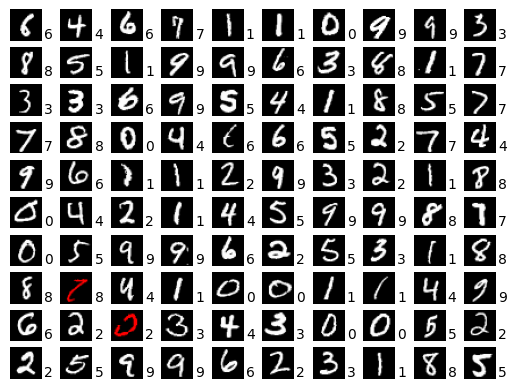

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.001223
Train Epoch: 9 [6400/60000 (11%)]	Loss: 0.000779
Train Epoch: 9 [12800/60000 (21%)]	Loss: 0.001417
Train Epoch: 9 [19200/60000 (32%)]	Loss: 0.000753
Train Epoch: 9 [25600/60000 (43%)]	Loss: 0.000131
Train Epoch: 9 [32000/60000 (53%)]	Loss: 0.000227
Train Epoch: 9 [38400/60000 (64%)]	Loss: 0.000190
Train Epoch: 9 [44800/60000 (75%)]	Loss: 0.000489
Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.000698
Train Epoch: 9 [57600/60000 (96%)]	Loss: 0.000515

Test set: Average loss: 0.0317, Accuracy: 9899/10000 (98.99%)



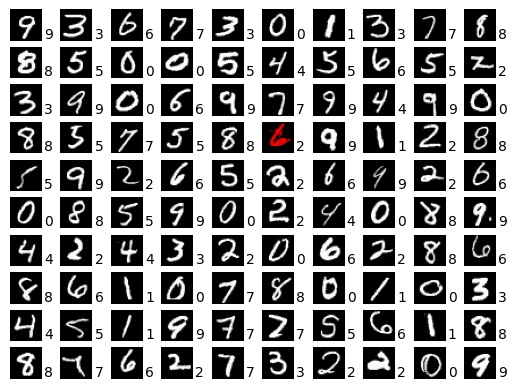

model: ConvNet3
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.374625


/tmp/ipykernel_87850/4109835594.py:36: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.060461
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.107205
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.117195
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.020978
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.054188
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.009773
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.015947
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.032796
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.005482

Test set: Average loss: 0.0512, Accuracy: 9843/10000 (98.43%)



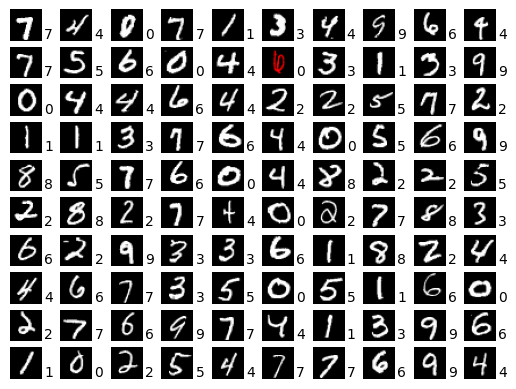

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.047553
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.005906
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.007928
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.017836
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.012921
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.010143
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.026100
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.014382
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.091071
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.160579

Test set: Average loss: 0.0273, Accuracy: 9908/10000 (99.08%)



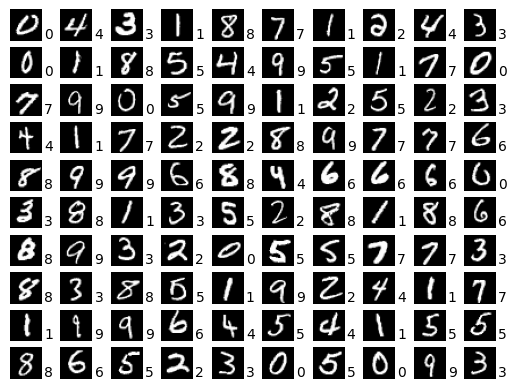

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.035309
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.003101
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.004518
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.021529
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.001903
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.065661
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.003099
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.003109
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.010187
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.014862

Test set: Average loss: 0.0257, Accuracy: 9909/10000 (99.09%)



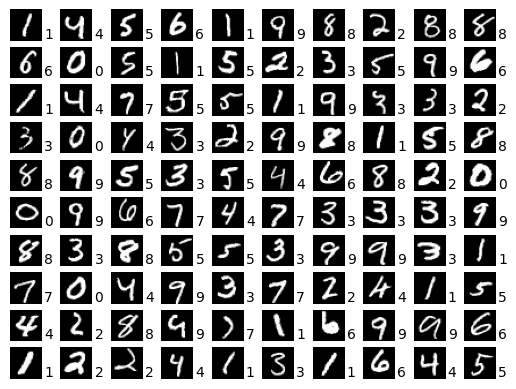

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.008146
Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.001467
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.001545
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.001110
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.000398
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.001222
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.004944
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.001565
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.006658
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.000829

Test set: Average loss: 0.0245, Accuracy: 9918/10000 (99.18%)



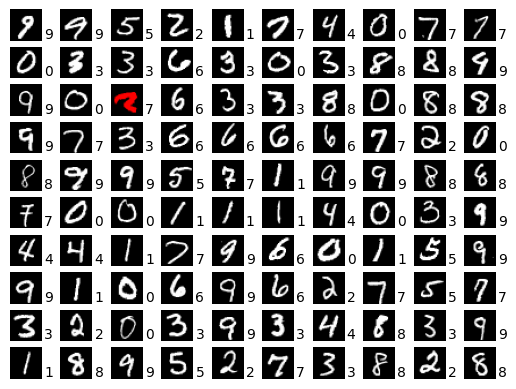

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.003251
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.001421
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.009737
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.001826
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.000539
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.000078
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.007090
Train Epoch: 4 [44800/60000 (75%)]	Loss: 0.000436
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.000744
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.001115

Test set: Average loss: 0.0235, Accuracy: 9933/10000 (99.33%)



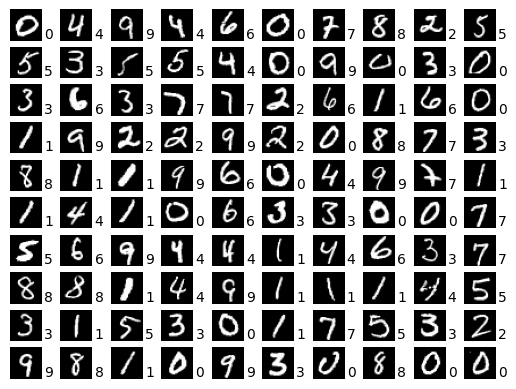

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.002600
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.000456
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.000719
Train Epoch: 5 [19200/60000 (32%)]	Loss: 0.001831
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.001100
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.000503
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.001420
Train Epoch: 5 [44800/60000 (75%)]	Loss: 0.002793
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.001793
Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.002124

Test set: Average loss: 0.0232, Accuracy: 9927/10000 (99.27%)



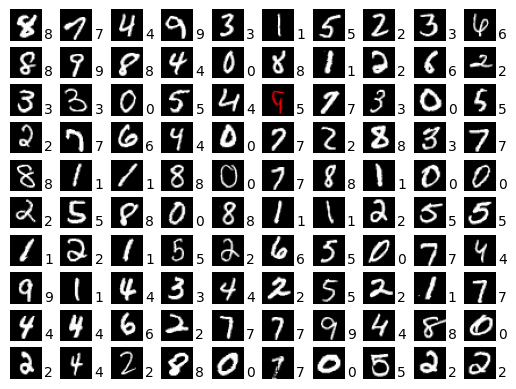

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.025795
Train Epoch: 6 [6400/60000 (11%)]	Loss: 0.000735
Train Epoch: 6 [12800/60000 (21%)]	Loss: 0.000766
Train Epoch: 6 [19200/60000 (32%)]	Loss: 0.000156
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.001753
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.005775
Train Epoch: 6 [38400/60000 (64%)]	Loss: 0.001636
Train Epoch: 6 [44800/60000 (75%)]	Loss: 0.000987
Train Epoch: 6 [51200/60000 (85%)]	Loss: 0.000358
Train Epoch: 6 [57600/60000 (96%)]	Loss: 0.000051

Test set: Average loss: 0.0234, Accuracy: 9926/10000 (99.26%)



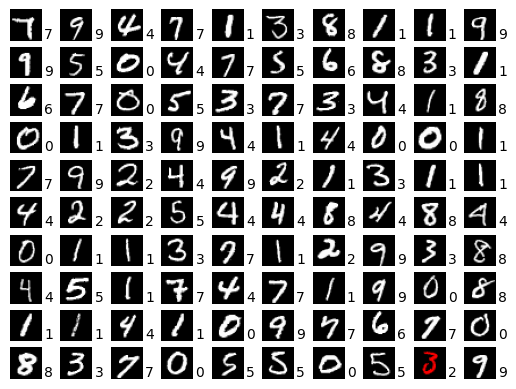

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.000358
Train Epoch: 7 [6400/60000 (11%)]	Loss: 0.000368
Train Epoch: 7 [12800/60000 (21%)]	Loss: 0.000607
Train Epoch: 7 [19200/60000 (32%)]	Loss: 0.000300
Train Epoch: 7 [25600/60000 (43%)]	Loss: 0.004278
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.000702
Train Epoch: 7 [38400/60000 (64%)]	Loss: 0.000422
Train Epoch: 7 [44800/60000 (75%)]	Loss: 0.001003
Train Epoch: 7 [51200/60000 (85%)]	Loss: 0.000636
Train Epoch: 7 [57600/60000 (96%)]	Loss: 0.001250

Test set: Average loss: 0.0236, Accuracy: 9927/10000 (99.27%)



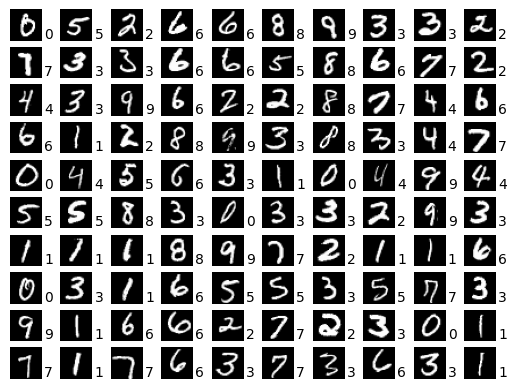

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.010159
Train Epoch: 8 [6400/60000 (11%)]	Loss: 0.000646
Train Epoch: 8 [12800/60000 (21%)]	Loss: 0.003627
Train Epoch: 8 [19200/60000 (32%)]	Loss: 0.002912
Train Epoch: 8 [25600/60000 (43%)]	Loss: 0.000263
Train Epoch: 8 [32000/60000 (53%)]	Loss: 0.000136
Train Epoch: 8 [38400/60000 (64%)]	Loss: 0.000385
Train Epoch: 8 [44800/60000 (75%)]	Loss: 0.002903
Train Epoch: 8 [51200/60000 (85%)]	Loss: 0.001236
Train Epoch: 8 [57600/60000 (96%)]	Loss: 0.000669

Test set: Average loss: 0.0241, Accuracy: 9924/10000 (99.24%)



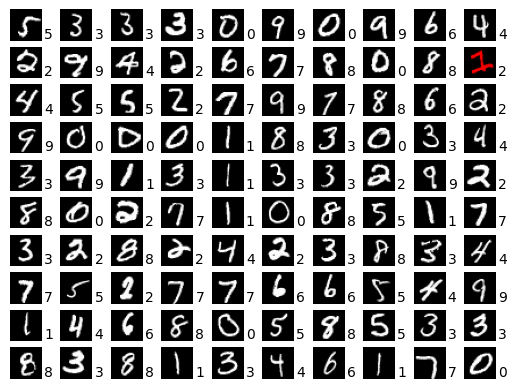

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.000870
Train Epoch: 9 [6400/60000 (11%)]	Loss: 0.000091
Train Epoch: 9 [12800/60000 (21%)]	Loss: 0.087532
Train Epoch: 9 [19200/60000 (32%)]	Loss: 0.000246
Train Epoch: 9 [25600/60000 (43%)]	Loss: 0.000173
Train Epoch: 9 [32000/60000 (53%)]	Loss: 0.002199
Train Epoch: 9 [38400/60000 (64%)]	Loss: 0.000670
Train Epoch: 9 [44800/60000 (75%)]	Loss: 0.000861
Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.000549
Train Epoch: 9 [57600/60000 (96%)]	Loss: 0.000231

Test set: Average loss: 0.0243, Accuracy: 9925/10000 (99.25%)



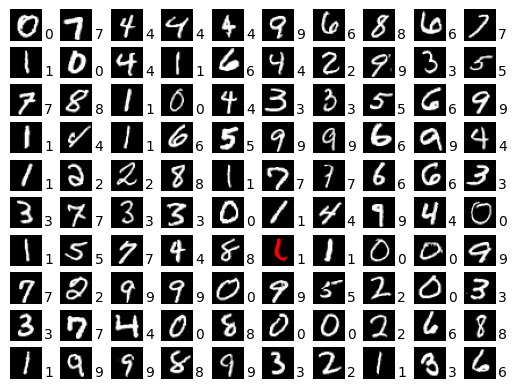

In [ ]:
# hyper parameters
batch_size = 64
test_batch_size = 1000
epochs = 10
lr = 1.0
gamma = 0.7
log_interval = 100

# use GPU if available
use_cuda = torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

# initialize data loaders
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, 
    transform=transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.1307,), (0.3081,))
    ])),
    batch_size=test_batch_size, shuffle=True, **kwargs)

#List of all models to run
modellist = [
    FCNet1(),  
    FCNet2(),  
    FCNet3(), 
    ConvNet1(),
    ConvNet2(),
    ConvNet3()
    ]

data = {}
file_path = "data.json" 

# Check if the file exists 
if not os.path.isfile(file_path): # Create the file 
    with open(file_path, 'w') as file:
        file.write('{}')

with open(file_path, 'r') as json_file:
    data = json.load(json_file)

for model in modellist:         #Iterate over all models
    print(f"model: {model.name}")
    if model.name in data:
        continue

    loss = []
    acc = []
    data[model.name] = {}
    if use_cuda:
        model = model.cuda()

    # initialize optimizer and scheduler
    optimizer = optim.Adadelta(model.parameters(), lr=lr)
    scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

    #Loop to add data from epochs to data array
    for epoch in range(0, epochs):
        # train one epoch
        loss.append(train(model, use_cuda, train_loader, optimizer, epoch, log_interval))
        
        # run on test dataset
        acc.append(validate(model, use_cuda, test_loader))
        scheduler.step()

    data[str(model.name)] = {'acc': acc, 'loss': loss}     #Append to data array 

    with open(file_path, 'w') as json_file:
        json.dump(data, json_file, indent=4)
    
    torch.save(model.state_dict(), "models/mnist/checkpoint.pt")
###------------------------------------------------- ganz unten folgen plots zu allen implementierten Netzwerken

To run all models, please delete the data.json file. To only view the plots please leave the data.json file in the same directory where the notebook is executed.

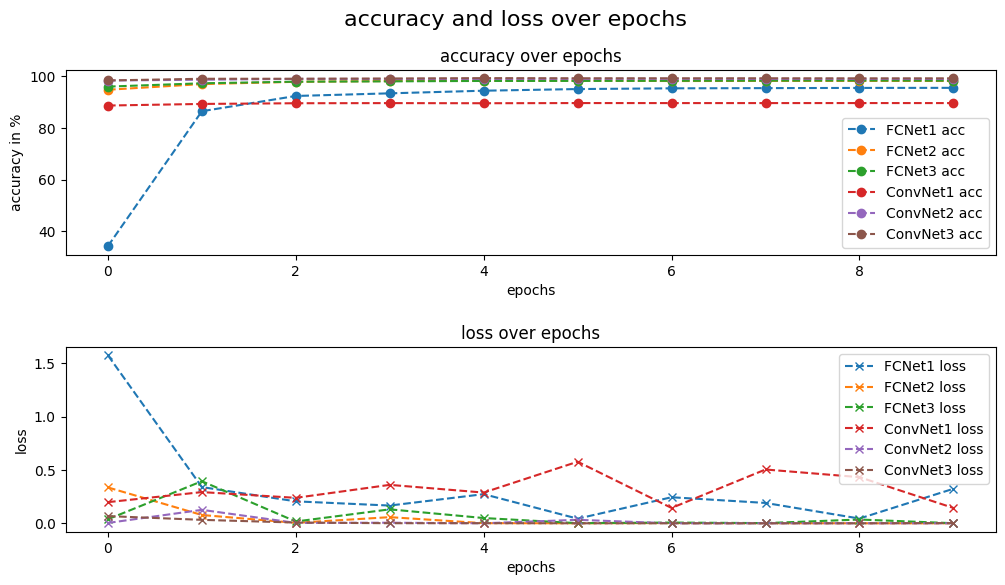

In [ ]:
#Function to plot accuracy and loss data for multiple models
def plotdata(dataDict: dict) -> None:
    #Create a figure with two subplots arranged vertically (2 rows, 1 column)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))
    plt.subplots_adjust(wspace=0.5, hspace=0.5)  #Adjust space between subplots

    #Set the overall title for the figure
    fig.suptitle('Accuracy and Loss over Epochs', fontsize=16)

    #Iterate over the models in the data dictionary
    for model in dataDict:
        #Plot accuracy values for the current model on the first subplot (ax1)
        ax1.plot(dataDict[model]['acc'], 'o--', label=f'{model} acc')
        #Plot loss values for the current model on the second subplot (ax2)
        ax2.plot(dataDict[model]['loss'], 'x--', label=f'{model} loss')

    #Configure the first subplot (accuracy over epochs)
    ax1.set_title("Accuracy over Epochs")  #Title for the accuracy plot
    ax1.set_ylabel("Accuracy in %")        #Y-axis label for accuracy
    ax1.set_xlabel("Epochs")              #X-axis label for epochs

    #Configure the second subplot (loss over epochs)
    ax2.set_title("Loss over Epochs")     #Title for the loss plot
    ax2.set_ylabel("Loss")                #Y-axis label for loss
    ax2.set_xlabel("Epochs")              #X-axis label for epochs

    #Add legends to both subplots for model labels
    ax2.legend()
    ax1.legend()

    #Save the figure to an image file
    plt.savefig("Model_Vergleich.png")

#Open and read data from a JSON file
with open("data.json", 'r') as json_file:
    data = json.load(json_file)

#Call the plotdata function with the loaded data
plotdata(dataDict=data)